In [1]:
from modules.preprocessing import *
import pickle
import pandas as pd
from tqdm import tqdm
import gensim
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import random
import tensorflow as tf

In [2]:
datasets = pickle.load(open("dataset/organized_dataset.pkl", "rb"))

df = pd.DataFrame(datasets, columns = ['text', 'tokens', 'source', 'label', 'anger','disgust','fear', 'joy', 'love', 'noemo', 'sadness', 'surprise']) 
df.drop_duplicates(['source'])

,text,tokens,source,label,anger,disgust,fear,joy,love,noemo,sadness,surprise
0,"Remember what she said in my last letter? ""","[rememb, what, she, said, in, my, last, letter]",emobank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10062,@PressSec sounds so defensive &amp; combative...,"[twitterusernam, sound, so, defens, , amp, com...",grounded_emotions,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.00,NaN
12647,@tiffanylue i know i was listenin to bad habi...,"[twitterusernam, i, know, , i, wa, listenin, t...",crowdflower,NaN,0.00,0.00,0.0,0.0,0.0,1.0,0.00,0.0
52387,"I'm a #Republican, but if I have to hear my mo...","[i, 'm, a, republican, but, if, i, have, to, h...",electoraltweets,NaN,0.00,1.00,0.0,0.0,NaN,0.0,0.00,0.0
56443,Thinks that @melbahughes had a great 50th birt...,"[think, that, twitterusernam, had, a, great, 5...",tec,NaN,0.00,0.00,0.0,0.0,NaN,NaN,0.00,1.0
77494,Mortar assault leaves at least 18 dead,"[mortar, assault, leav, atleast18, dead]",affectivetext,NaN,0.22,0.02,0.6,0.0,NaN,NaN,0.64,0.0
78744,He who exalts himself shall be humbled; a...,"[he, who, exalt, himself, shall, , be, humbl, ...",ssec,NaN,1.00,1.00,0.0,1.0,NaN,NaN,0.00,0.0
83612,This did the trick : the boys now have a more ...,"[thi, did, the, trick, the, boy, now, have, a,...",emotion-cause,NaN,0.00,0.00,0.0,1.0,NaN,NaN,0.00,0.0
86026,The kitchen stinks .,"[the, kitchen, stink]",dailydialog,NaN,0.00,1.00,0.0,0.0,NaN,0.0,0.00,0.0
189005,@ZubairSabirPTI pls dont insult the word 'Molna',"[twitterusernam, , pl, do, nt, insult, the, wo...",emoint,NaN,1.00,NaN,0.0,0.0,NaN,NaN,0.00,NaN


In [3]:
## config
size_word2vec = 300
maxlen = MAX_SEQUENCE_LENGTH = 35


sentiments = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [4]:
filename = 'models/ft_'+str(size_word2vec)+'.pkl'

try:
    w2v = pickle.load(open(filename, 'rb'))
except:
    w2v = gensim.models.FastText(df['tokens'].values,size=size_word2vec, workers=8)
    # w2v = gensim.models.Word2Vec(df['tokens'].values,size=size_word2vec, workers=8, compute_loss=True, )
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(w2v, output, pickle.HIGHEST_PROTOCOL)

MAX_NB_WORDS = len(w2v.wv.vocab)
nb_words = min(MAX_NB_WORDS, len(w2v.wv.vocab))


# training_loss = w2v.get_latest_training_loss()
# print(training_loss)

print(w2v.wv.most_similar(positive=['woman', 'king'], negative=['man']))
print(w2v.wv.most_similar('gr8'))
print(w2v.wv.most_similar('new_york'))
print(w2v.wv.most_similar('twitter_usernam'))

[('king"', 0.8604748249053955), ('kingdom', 0.8294626474380493), ('ding', 0.8038256764411926), ('ting', 0.8011561036109924), ('djing', 0.791709840297699), ('mening', 0.7803318500518799), ('bing', 0.7801820635795593), ('shepherd', 0.7775712013244629), ('grandkid', 0.7763444781303406), ('slaughter', 0.7662848830223083)]
[('grr', 0.954753577709198), ('greg', 0.9241389036178589), ('graze', 0.9123169183731079), ('grub', 0.9089978337287903), ('graz', 0.8987541794776917), ('gravi', 0.8892017006874084), ('grey', 0.8847296237945557), ('grasp', 0.8821795582771301), ('grrr', 0.871491551399231), ('greec', 0.8586562275886536)]
[('newyork', 0.9463077187538147), ('newyorkc', 0.888946533203125), ('newyorktim', 0.8880877494812012), ('network', 0.8863909244537354), ('newark', 0.8819414377212524), ('neworlean', 0.8645150661468506), ('newbi', 0.839887797832489), ('newjersey', 0.8390856981277466), ('newborn', 0.8387944102287292), ('newcastl', 0.8368891477584839)]
[('twitterusername-', 0.9799015522003174), 

In [5]:
sentData = df.loc[df['source'].isin(['dailydialog', 'electoraltweets', 'crowdflower'])]
sentData.drop_duplicates(['source'])

,text,tokens,source,label,anger,disgust,fear,joy,love,noemo,sadness,surprise
12647,@tiffanylue i know i was listenin to bad habi...,"[twitterusernam, i, know, , i, wa, listenin, t...",crowdflower,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52387,"I'm a #Republican, but if I have to hear my mo...","[i, 'm, a, republican, but, if, i, have, to, h...",electoraltweets,NaN,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
86026,The kitchen stinks .,"[the, kitchen, stink]",dailydialog,NaN,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0


In [6]:
def getIndex(t):
    try:
        return w2v.wv.vocab[t].index
    except:
        return 0
sentData[sentiments].sum()

def getSentData(sentiment):
    labels = [sentiment]# ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

    sequences = [[getIndex(t) for t in comment]
                for comment in sentData['tokens']]

    data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    y = sentData[labels].values
    # print('Shape of data tensor:', data.shape)
    # print('Shape of label tensor:', y.shape)

    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)
    #random over sample
    ros = RandomOverSampler(random_state=42)
    # define the undersampling method
    undersample = NearMiss(version=1, n_neighbors=3)
    # transform the dataset
    x_test, y_test = ros.fit_resample(x_test, y_test)

    x_train, y_train = ros.fit_resample(x_train, y_train)

    return x_train, y_train, x_test, y_test

In [7]:
def model_gru(embedding_matrix, embed_size):

    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
 
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(35, return_sequences=True))(x)
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
    conc = tf.keras.layers.concatenate([avg_pool, max_pool])
    conc = tf.keras.layers.Dense(70, activation="relu")(conc)

    conc = tf.keras.layers.Dropout(0.5)(conc)
    outp = tf.keras.layers.Dense(1, activation="sigmoid")(conc)
    model = tf.keras.models.Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/25
932/932 [==============================] - 79s 85ms/step - loss: 0.4129 - accuracy: 0.8077 - val_loss: 0.2387 - val_accuracy: 0.9461
Epoch 2/25
932/932 [==============================] - 78s 84ms/step - loss: 0.2000 - accuracy: 0.9281 - val_loss: 0.2233 - val_accuracy: 0.9347
Epoch 3/25
932/932 [==============================] - 79s 84ms/step - loss: 0.1284 - accuracy: 0.9593 - val_loss: 0.0532 - val_accuracy: 0.9932
Epoch 4/25
932/932 [==============================] - 78s 84ms/step - loss: 0.0976 - accuracy: 0.9711 - val_loss: 0.0770 - val_accuracy: 0.9883
Epoch 5/25
932/932 [==============================] - 79s 84ms/step - loss: 0.0830 - accuracy: 0.9761 - val_loss: 0.0295 - val_accuracy: 0.9966
Epoch 6/25
932/932 [==============================] - 78s 84ms/step - loss: 0.0722 - accuracy: 0.9794 - val_loss: 0.0752 - val_accuracy: 0.9832
Epoch 7/25
932/932 [==============================] - 79s 84ms/step - loss: 0.0653 - accuracy: 0.9817 - val_loss: 0.0553 - val_accuracy:

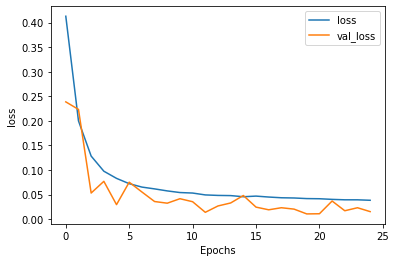

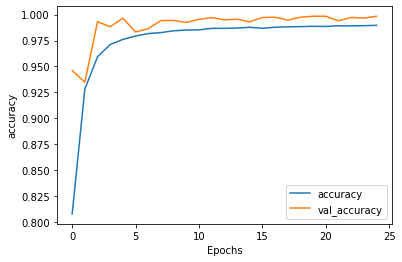

 17%|█▋        | 1/6 [33:08<2:45:41, 1988.36s/it]

Epoch 1/25
938/938 [==============================] - 80s 85ms/step - loss: 0.2085 - accuracy: 0.9204 - val_loss: 0.2867 - val_accuracy: 0.8767
Epoch 2/25
938/938 [==============================] - 78s 83ms/step - loss: 0.0687 - accuracy: 0.9820 - val_loss: 0.0746 - val_accuracy: 0.9858
Epoch 3/25
938/938 [==============================] - 78s 83ms/step - loss: 0.0507 - accuracy: 0.9879 - val_loss: 0.0161 - val_accuracy: 0.9997
Epoch 4/25
938/938 [==============================] - 79s 84ms/step - loss: 0.0415 - accuracy: 0.9906 - val_loss: 0.0180 - val_accuracy: 0.9985
Epoch 5/25
938/938 [==============================] - 78s 84ms/step - loss: 0.0380 - accuracy: 0.9917 - val_loss: 0.0227 - val_accuracy: 0.9973
Epoch 6/25
938/938 [==============================] - 79s 84ms/step - loss: 0.0367 - accuracy: 0.9918 - val_loss: 0.0108 - val_accuracy: 0.9996
Epoch 7/25
938/938 [==============================] - 79s 84ms/step - loss: 0.0339 - accuracy: 0.9927 - val_loss: 0.0194 - val_accuracy:

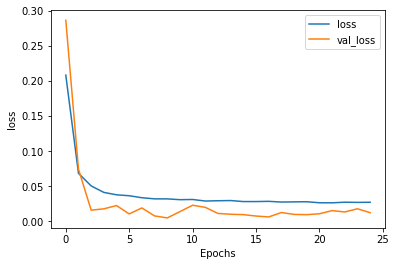

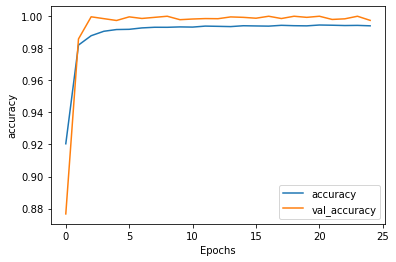

 33%|███▎      | 2/6 [1:06:27<2:12:45, 1991.48s/it]

Epoch 1/25
895/895 [==============================] - 76s 85ms/step - loss: 0.4199 - accuracy: 0.8031 - val_loss: 0.3705 - val_accuracy: 0.9107
Epoch 2/25
895/895 [==============================] - 76s 85ms/step - loss: 0.3369 - accuracy: 0.8495 - val_loss: 0.2417 - val_accuracy: 0.9677
Epoch 3/25
895/895 [==============================] - 76s 85ms/step - loss: 0.2948 - accuracy: 0.8732 - val_loss: 0.2062 - val_accuracy: 0.9841
Epoch 4/25
895/895 [==============================] - 75s 84ms/step - loss: 0.2627 - accuracy: 0.8914 - val_loss: 0.2325 - val_accuracy: 0.9579
Epoch 5/25
895/895 [==============================] - 75s 84ms/step - loss: 0.2415 - accuracy: 0.9033 - val_loss: 0.1630 - val_accuracy: 0.9898
Epoch 6/25
895/895 [==============================] - 76s 85ms/step - loss: 0.2236 - accuracy: 0.9128 - val_loss: 0.1495 - val_accuracy: 0.9915
Epoch 7/25
895/895 [==============================] - 76s 85ms/step - loss: 0.2097 - accuracy: 0.9198 - val_loss: 0.1944 - val_accuracy:

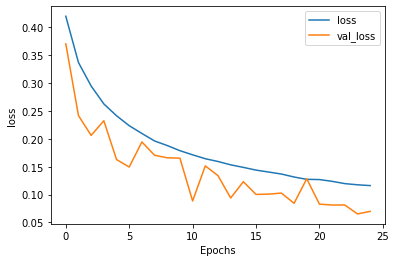

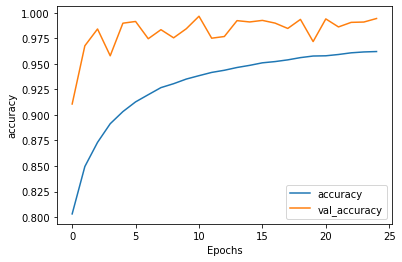

 50%|█████     | 3/6 [1:38:21<1:38:24, 1968.27s/it]

Epoch 1/25
806/806 [==============================] - 68s 85ms/step - loss: 0.5490 - accuracy: 0.7228 - val_loss: 0.5146 - val_accuracy: 0.7543
Epoch 2/25
806/806 [==============================] - 69s 85ms/step - loss: 0.4992 - accuracy: 0.7585 - val_loss: 0.5524 - val_accuracy: 0.7454
Epoch 3/25
806/806 [==============================] - 68s 85ms/step - loss: 0.4746 - accuracy: 0.7726 - val_loss: 0.5233 - val_accuracy: 0.7757
Epoch 4/25
806/806 [==============================] - 69s 85ms/step - loss: 0.4524 - accuracy: 0.7863 - val_loss: 0.5854 - val_accuracy: 0.7269
Epoch 5/25
806/806 [==============================] - 69s 85ms/step - loss: 0.4308 - accuracy: 0.7989 - val_loss: 0.3998 - val_accuracy: 0.8831
Epoch 6/25
806/806 [==============================] - 69s 86ms/step - loss: 0.4122 - accuracy: 0.8099 - val_loss: 0.4257 - val_accuracy: 0.8658
Epoch 7/25
806/806 [==============================] - 69s 85ms/step - loss: 0.3949 - accuracy: 0.8202 - val_loss: 0.3460 - val_accuracy:

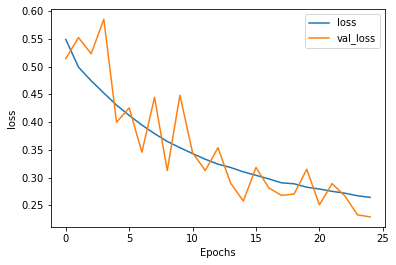

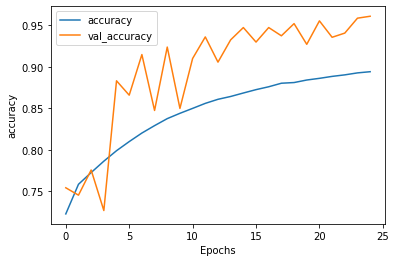

 67%|██████▋   | 4/6 [2:07:26<1:03:22, 1901.29s/it]

Epoch 1/25
911/911 [==============================] - 79s 87ms/step - loss: 0.4293 - accuracy: 0.7985 - val_loss: 0.3719 - val_accuracy: 0.8880
Epoch 2/25
911/911 [==============================] - 77s 85ms/step - loss: 0.3245 - accuracy: 0.8602 - val_loss: 0.2377 - val_accuracy: 0.9577
Epoch 3/25
911/911 [==============================] - 78s 85ms/step - loss: 0.2565 - accuracy: 0.8990 - val_loss: 0.1399 - val_accuracy: 0.9850
Epoch 4/25
911/911 [==============================] - 78s 85ms/step - loss: 0.2160 - accuracy: 0.9198 - val_loss: 0.2018 - val_accuracy: 0.9679
Epoch 5/25
911/911 [==============================] - 79s 86ms/step - loss: 0.1868 - accuracy: 0.9341 - val_loss: 0.1280 - val_accuracy: 0.9879
Epoch 6/25
911/911 [==============================] - 78s 86ms/step - loss: 0.1673 - accuracy: 0.9430 - val_loss: 0.2174 - val_accuracy: 0.9436
Epoch 7/25
911/911 [==============================] - 79s 87ms/step - loss: 0.1562 - accuracy: 0.9473 - val_loss: 0.0912 - val_accuracy:

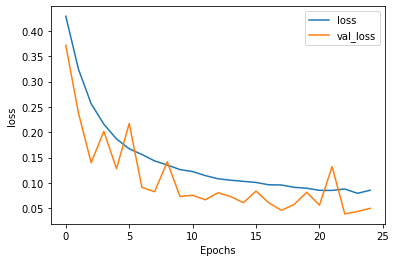

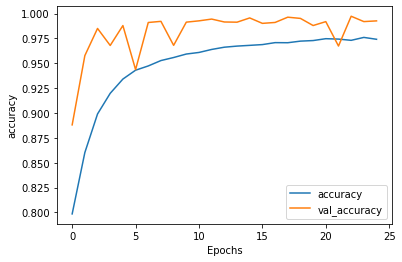

 83%|████████▎ | 5/6 [2:40:23<32:04, 1924.13s/it]  

Epoch 1/25
924/924 [==============================] - 80s 86ms/step - loss: 0.4635 - accuracy: 0.7610 - val_loss: 0.3778 - val_accuracy: 0.8710
Epoch 2/25
924/924 [==============================] - 80s 87ms/step - loss: 0.3087 - accuracy: 0.8592 - val_loss: 0.1996 - val_accuracy: 0.9610
Epoch 3/25
924/924 [==============================] - 79s 86ms/step - loss: 0.2144 - accuracy: 0.9152 - val_loss: 0.1458 - val_accuracy: 0.9811
Epoch 4/25
924/924 [==============================] - 79s 85ms/step - loss: 0.1639 - accuracy: 0.9405 - val_loss: 0.0821 - val_accuracy: 0.9938
Epoch 5/25
924/924 [==============================] - 79s 85ms/step - loss: 0.1319 - accuracy: 0.9549 - val_loss: 0.0843 - val_accuracy: 0.9878
Epoch 6/25
924/924 [==============================] - 79s 86ms/step - loss: 0.1156 - accuracy: 0.9616 - val_loss: 0.0738 - val_accuracy: 0.9914
Epoch 7/25
924/924 [==============================] - 79s 85ms/step - loss: 0.1009 - accuracy: 0.9677 - val_loss: 0.0387 - val_accuracy:

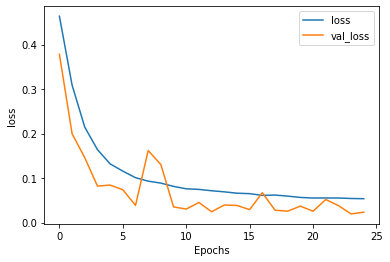

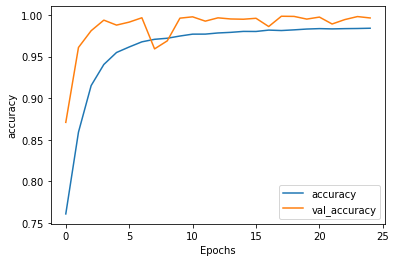

100%|██████████| 6/6 [3:13:32<00:00, 1935.46s/it]


In [8]:
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def f1_smart(y_true, y_pred):
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = metrics.f1_score(y_true, (y_pred > thresh).astype(int))
        thresholds.append([thresh, res])
        printout = "F1 score at threshold {0} is {1}".format(thresh, res)
        # print(printout)
    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    best_f1 = thresholds[0][1]
    print("Best threshold: ", best_thresh)
    return best_f1, best_thresh

def train(sentiment):
    model = model_gru(w2v.wv.vectors, size_word2vec)

    x_train, y_train, x_test, y_test = getSentData(sentiment)
    hist = model.fit(x_train, y_train,
                        validation_split=0.1,
                        epochs=25,
                        batch_size=250,
                        shuffle=True, # ?
                        verbose=1)
    print(sentiment.upper())
    score = model.evaluate(x_test, y_test, verbose=1)
    y_pred_test = model.predict([x_test], batch_size=250, verbose=0)

    f1, threshold = f1_smart(y_test, y_pred_test)
    printout = 'Optimal F1: {} at threshold: {}'.format(f1, threshold)
    print(printout)
    print("Train Loss:", hist.history['loss'][-1])
    print("Train Accuracy:", hist.history['accuracy'][-1])

    plot_graphs(hist, 'loss')
    plot_graphs(hist, 'accuracy')
    
    return model

models = dict()
for s in tqdm(sentiments):
    models[s] = train(s)

In [9]:
def getModelInput(phrase):
    x = cleanText(phrase)
    x = [getIndex(t) for t in x]
    x = pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)
    return x

def getEmotions(phrase):
    # sentiments = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
    x = getModelInput(phrase)
    return [models[s].predict(x) for s in sentiments]

In [11]:
model_json = model_gru(w2v.wv.vectors, size_word2vec).to_json()
with open("models/bi-gru"+str(size_word2vec)+".json", "w") as json_file:
    json_file.write(model_json)

In [12]:
for s in sentiments:
    models[s].save_weights('models/'+s+'_weights.h5')